In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import os
from matplotlib.lines import Line2D

In [2]:
path = '/Users/zcaspar/codes/Diagnostics2/'



In [3]:
ds = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_param_fit_T80*'))] #local

In [51]:

Te = [d.E_u_avg.sel(param='Tt') for d in ds]#[xr.concat([d.E_u_avg.sel(param='Tt'),d.E_v_avg.sel(param='Tt')],dim='ybin') for d in ds]
Tl = [d.L_u_avg.sel(param='Tt') for d in ds]#[xr.concat([d.L_u_avg.sel(param='Tt'),d.L_v_avg.sel(param='Tt')],dim='ybin') for d in ds]
Tbe = [d.E_u_avg.sel(param='Tb') for d in ds]#[xr.concat([d.E_u_avg.sel(param='Tb'),d.E_v_avg.sel(param='Tb')],dim='ybin') for d in ds]
Tbl = [d.L_u_avg.sel(param='Tb') for d in ds]#[xr.concat([d.L_u_avg.sel(param='Tb'),d.L_v_avg.sel(param='Tb')],dim='ybin') for d in ds]
Ubar = [d.Uprime for d in ds]

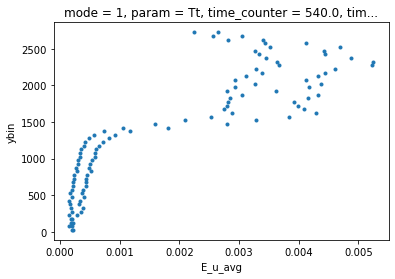

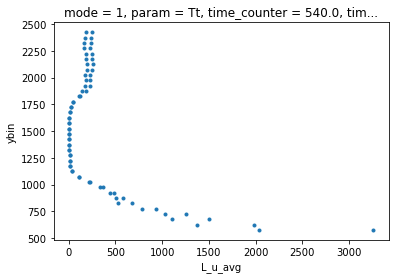

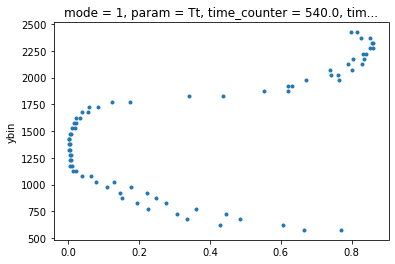

In [6]:
(1/Te[0]).plot.line('.',y='ybin')
plt.figure()
(Tl[0]).plot.line('.',y='ybin')
plt.figure()
(Tl[0]/Te[0]).plot.line('.',y='ybin')

In [7]:
def phi_mu(tau,Tbar):
    return 1-np.exp(-tau/Tbar)
def phi_sigma(tau,Tbar):
    return 1-2*(1-np.exp(-tau/Tbar))/tau+(1+np.exp(-2*tau/Tbar))/(2*tau)

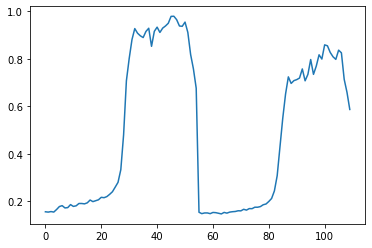

In [34]:
from scipy.stats import norm
plt.plot(norm.cdf((1/Te[0]).values, (1/Te[0]).mean(), (1/Te[0]).std()))

In [8]:
vmodes = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_waves_modes*'))] #local
Lt = [vm.lwave.sel(mode=1) for vm in vmodes]

In [58]:
Tbmean = [(Tbe[i]+Tbl[i])/2 for i,x in enumerate(Tbe)]

In [46]:
Tbe[0]

<xarray.DataArray 'E_u_avg' (ybin: 110)>
array([4.15081755e-04, 7.26850021e+04, 4.49933537e+03, 8.09057129e-05,
       5.14688957e+04, 1.70984938e-03, 7.35904700e+01, 3.35364306e+02,
       3.35156732e+02, 1.79881514e+02, 7.86008581e+05, 2.47988170e+03,
       8.49281713e+01, 1.29005774e+03, 4.35053703e+01, 7.22487937e+02,
       7.55315280e+02, 5.27400901e+01, 6.08548088e+02, 6.14300272e+01,
       7.55353481e+01, 1.91530209e+02, 8.15356894e+01, 5.27066745e+01,
       5.22155183e+01, 4.33139358e+01, 4.37527171e+01, 5.10846058e+01,
       5.25572814e+01, 4.86631328e+01, 5.19679313e+01, 5.06213299e+01,
       6.97222581e+01, 6.18315571e+01, 8.51325525e+01, 1.53325928e+02,
       1.24000651e+01, 5.96700273e+02, 1.97798133e-06, 1.88451004e-05,
       2.97755231e-05, 2.11949814e-04, 1.48739493e-05, 1.07083809e-05,
       8.45468601e-05, 8.54618809e-02, 1.63526910e-04, 1.81558231e-04,
       1.35800491e+00, 8.46044930e-02, 1.59614793e-03, 1.96836265e-04,
       1.12429080e-04, 1.06145237e-03, 2.37236703e-04, 4.21868812e+00,
       5.54782340e-05, 6.16907413e+04, 8.16445795e+01, 6.88140651e-04,
       1.80353198e+00, 2.42704158e+03, 4.20635008e+03, 2.09272443e-03,
       3.50990041e+02, 5.68409073e+02, 6.08816859e+02, 4.23493803e+02,
       4.75254192e+02, 2.47632397e+02, 7.19011655e+02, 1.21831664e+02,
       1.06104419e+02, 1.28154405e+02, 1.13411514e+02, 1.05907958e+02,
       1.06140623e+02, 3.62141511e-04, 6.20447560e+01, 5.57840605e+01,
       4.48451046e+01, 4.32241278e+01, 5.15598657e+01, 6.24441764e+01,
       6.31284679e+01, 5.02668638e+01, 4.02860531e+01, 4.84477402e+01,
       7.31014733e+01, 1.14710716e+02, 8.28076386e+00, 1.90392444e+01,
       2.72179357e-03, 3.21054617e-04, 8.92869408e-05, 2.97710164e-05,
       8.97343422e-05, 1.22836528e-07, 2.33865635e+02, 4.09761557e-04,
       1.02344226e-03, 8.58578887e-04, 3.01852286e-04, 1.59781423e-03,
       6.07902640e-07, 6.97323389e-04, 4.79206503e+01, 2.23391727e-04,
       1.92729176e-03, 1.93379464e-03])
Coordinates:
    mode          int64 1
    param         <U2 'Tb'
    time_counter  float64 540.0
    time_instant  float64 540.0
  * ybin          (ybin) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03

In [30]:
Tbmean[0].ybin.values

array([  25.,   75.,  125.,  175.,  225.,  275.,  325.,  375.,  425.,
        475.,  525.,  575.,  625.,  675.,  725.,  775.,  825.,  875.,
        925.,  975., 1025., 1075., 1125., 1175., 1225., 1275., 1325.,
       1375., 1425., 1475., 1525., 1575., 1625., 1675., 1725., 1775.,
       1825., 1875., 1925., 1975., 2025., 2075., 2125., 2175., 2225.,
       2275., 2325., 2375., 2425., 2475., 2525., 2575., 2625., 2675.,
       2725.,   25.,   75.,  125.,  175.,  225.,  275.,  325.,  375.,
        425.,  475.,  525.,  575.,  625.,  675.,  725.,  775.,  825.,
        875.,  925.,  975., 1025., 1075., 1125., 1175., 1225., 1275.,
       1325., 1375., 1425., 1475., 1525., 1575., 1625., 1675., 1725.,
       1775., 1825., 1875., 1925., 1975., 2025., 2075., 2125., 2175.,
       2225., 2275., 2325., 2375., 2425., 2475., 2525., 2575., 2625.,
       2675., 2725.])

In [35]:
len(Lt)

5

In [36]:
for i in range(len(Lt)):
    Lt[i] = Lt[i].assign_coords({'y_rho':Lt[i].y_rho.values*1e-3})

In [63]:
phi_sigma(Tl[i],Tbmean[i])

<xarray.DataArray (ybin: 55)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.99009071, 0.98614012, 0.98402489, 0.98135757,
       0.97624592, 0.96968922, 0.95932834, 0.95707327, 0.98041533,
       1.00118585, 1.01688475, 1.10990634, 1.14402226, 1.1593611 ,
       1.24660358, 1.35522179, 1.69538892, 1.91740071, 1.90615347,
       1.69543613, 1.48659752, 1.17899777, 1.12296595, 1.07690391,
       1.04481938, 1.09081572, 1.27915646, 1.08395748, 1.01975099,
       1.00638988, 0.92429689, 0.92065553, 0.97915367, 0.98443993,
       0.90322123, 0.93894027, 0.95214527, 0.90587083, 0.9431771 ,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * ybin          (ybin) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03
    time_instant  float64 540.0
    time_counter  float64 540.0
    mode          int64 1
    param         <U2 'Tt'

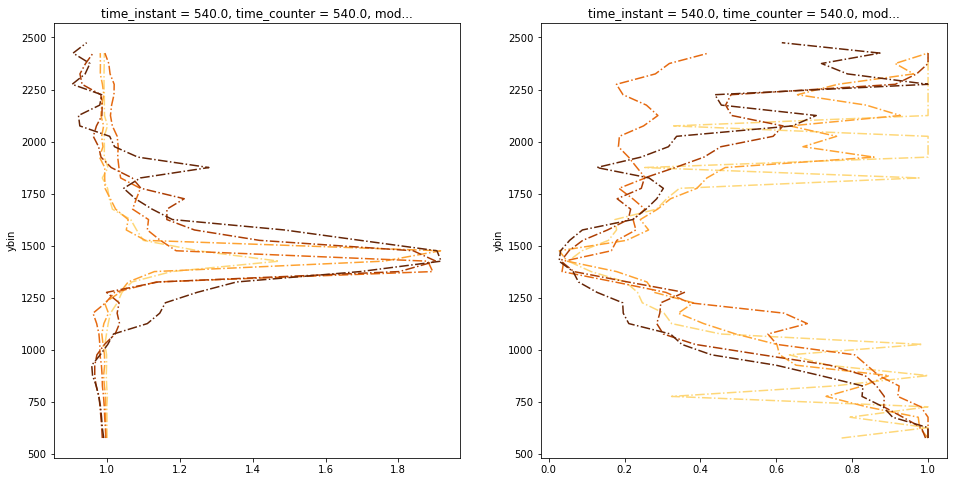

In [70]:
number = len(ds)
cmap = plt.get_cmap('YlOrBr')
colors = [cmap(i) for i in np.linspace(0.3, 1, number)]
fig,ax = plt.subplots(1,2,figsize=(16,8))
for i,d in enumerate(ds):
    phi_sigma(Tl[i],Tbmean[i]).plot.line('-.',ax=ax[0],y='ybin',c=colors[i])
    phi_mu(Tl[i],Tbmean[i]).plot.line('-.',ax=ax[1],y='ybin',c=colors[i])

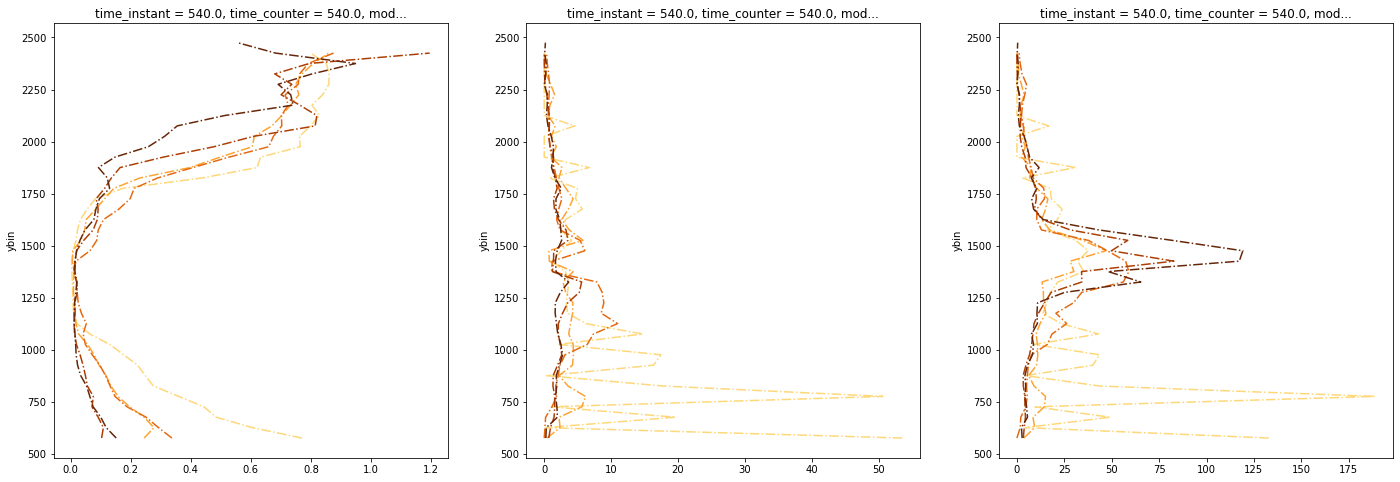

In [72]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
for i,d in enumerate(ds):
    x1 = Tl[i]/Te[i]
    x2 = Tbmean[i]**2*phi_mu(Tl[i],Tbmean[i])**2*(2*np.pi/d.Ta)**2
    x3 = (2*np.pi/d.Ta)**2*Tl[i]*Tbmean[i]*phi_sigma(Tl[i],Tbmean[i])
    x1.plot.line('-.',ax=ax[0],y='ybin',c=colors[i])
    x2.plot.line('-.',ax=ax[1],y='ybin',c=colors[i])
    x3.plot.line('-.',ax=ax[2],y='ybin',c=colors[i])

(0.0, 600.0)

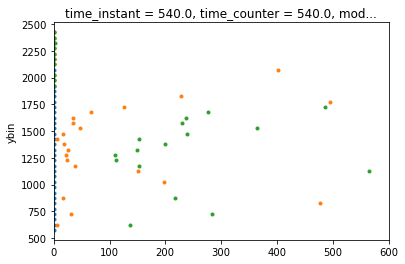

In [79]:
fig,ax = plt.subplots()
i = 0
x1 = Tl[i]/Te[i]
x2 = Tbmean[i]**2*phi_mu(Tl[i],Tbmean[i])**2*(2*np.pi/d.Ta)**2
x3 = (2*np.pi/d.Ta)**2*Tl[i]*Tbmean[i]*phi_sigma(Tl[i],Tbmean[i])
x1.plot.line('.',ax=ax,y='ybin')
x2.plot.line('.',ax=ax,y='ybin')
x3.plot.line('.',ax=ax,y='ybin')
ax.set_xlim(0,600)

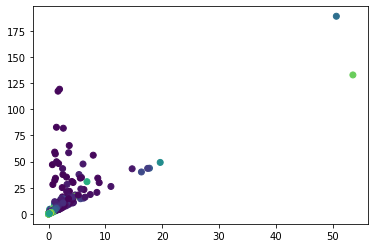

In [82]:
fig,ax = plt.subplots()
for i,d in enumerate(ds):
    x1 = Tl[i]/Te[i]
    x2 = Tbmean[i]**2*phi_mu(Tl[i],Tbmean[i])**2*(2*np.pi/d.Ta)**2
    x3 = (2*np.pi/d.Ta)**2*Tl[i]*Tbmean[i]*phi_sigma(Tl[i],Tbmean[i])
    ax.scatter(x2,x3,c=x1,vmin=0,vmax=1)
#x1.plot.line('.',ax=ax,y='ybin')
#x2.plot.line('.',ax=ax,y='ybin')
#x3.plot.line('.',ax=ax,y='ybin')
